Import external libraries.

In [3]:
#install.packages("dplyr")
library("readxl")
library("pscl")
library(caret)
library(yardstick)
library(data.table)
library(MLmetrics)
library(ggplot2)
library(MASS)
library(boot)

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘caret’

The following object is masked _by_ ‘.GlobalEnv’:

    RMSE

Warning message:
“package ‘yardstick’ was built under R version 3.6.3”For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.

Attaching package: ‘yardstick’

The following objects are masked from ‘package:caret’:

    precision, recall, sensitivity, specificity


Attaching package: ‘MLmetrics’

The following object is masked _by_ ‘.GlobalEnv’:

    RMSE

The following objects are masked from ‘package:caret’:



Read in tile count data for BEST2 and BEST3 and manual count data for BEST3. Change paths to ```barretts-segment-length-predictor``` directory as appropriate.

In [4]:
best2_tff3_tile_data <- read_excel("~/Documents/barrets-segment-length-predictor/data/BEST2_TFF3_AND_GASTRIC_TILE_COUNTS_QC_PASSING.xlsx")
best2_prague_length_data <- read_excel("~/Documents/barrets-segment-length-predictor/data/BEST2_ENDOSCOPY_CRF_CLEANED_SHORTENED.xlsx")
best3_tff3_tile_data <- read_excel('~/Documents/barrets-segment-length-predictor/data/BEST3_TFF3_AND_GASTRIC_TILE_COUNTS_QC_PASSING.xlsx')
best3_prague_length_data <- read.csv('~/Documents/barrets-segment-length-predictor/data/BEST3_ENDOSCOPY_CRF_CLEANED.csv')
best3_manual_tff3_data <- read_excel("~/Documents/barrets-segment-length-predictor/data/BEST3_TFF3_MANUAL_COUNTS.xlsx")

Explore relationship between manual count of TFF3 positive gland groups and C and M segment lengths

In [5]:
# remove rows missing count or segment length data
best3_manual_tff3_data <- setDT(best3_manual_tff3_data)
best3_manual_tff3_data <- na.omit(best3_manual_tff3_data, 
                                  cols=c('TFF3CountSlide1', 'TFF3CountSlide2', 'PragueCLength', 'PragueMLength'))

# add columns aggregating the counts of the two slides for each patient
best3_manual_tff3_data$TFF3CountSlideSum <- best3_manual_tff3_data$TFF3CountSlide1 + best3_manual_tff3_data$TFF3CountSlide2
best3_manual_tff3_data$TFF3CountSlideAvg <- best3_manual_tff3_data$TFF3CountSlideSum / 2

# correlation metrics
print('Prague C ~ TFF3 positive manual gland count slide1 Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlide1, best3_manual_tff3_data$PragueCLength, method = c("spearman"))

print('Prague C ~ TFF3 positive manual gland count slide2 Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlide2, best3_manual_tff3_data$PragueCLength, method = c("spearman"))

print('Prague C ~ TFF3 positive manual gland count avg Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlideAvg, best3_manual_tff3_data$PragueCLength, method = c("spearman"))

print('Prague M ~ TFF3 positive manual gland count slide1 Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlide1, best3_manual_tff3_data$PragueMLength, method = c("spearman"))

print('Prague M ~ TFF3 positive manual gland count slide2 Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlide2, best3_manual_tff3_data$PragueMLength, method = c("spearman"))

print('Prague M ~ TFF3 positive manual gland count avg Spearman rho')
cor(best3_manual_tff3_data$TFF3CountSlideAvg, best3_manual_tff3_data$PragueMLength, method = c("spearman"))

[1] "Prague C ~ TFF3 positive manual gland count slide1 Spearman rho"


[1] 0.3914214

[1] "Prague C ~ TFF3 positive manual gland count slide2 Spearman rho"


[1] 0.3775943

[1] "Prague C ~ TFF3 positive manual gland count avg Spearman rho"


[1] 0.3840293

[1] "Prague M ~ TFF3 positive manual gland count slide1 Spearman rho"


[1] 0.4284946

[1] "Prague M ~ TFF3 positive manual gland count slide2 Spearman rho"


[1] 0.3950152

[1] "Prague M ~ TFF3 positive manual gland count avg Spearman rho"


[1] 0.4189175

Plot BEST3 TFF3 manual count vs segment length

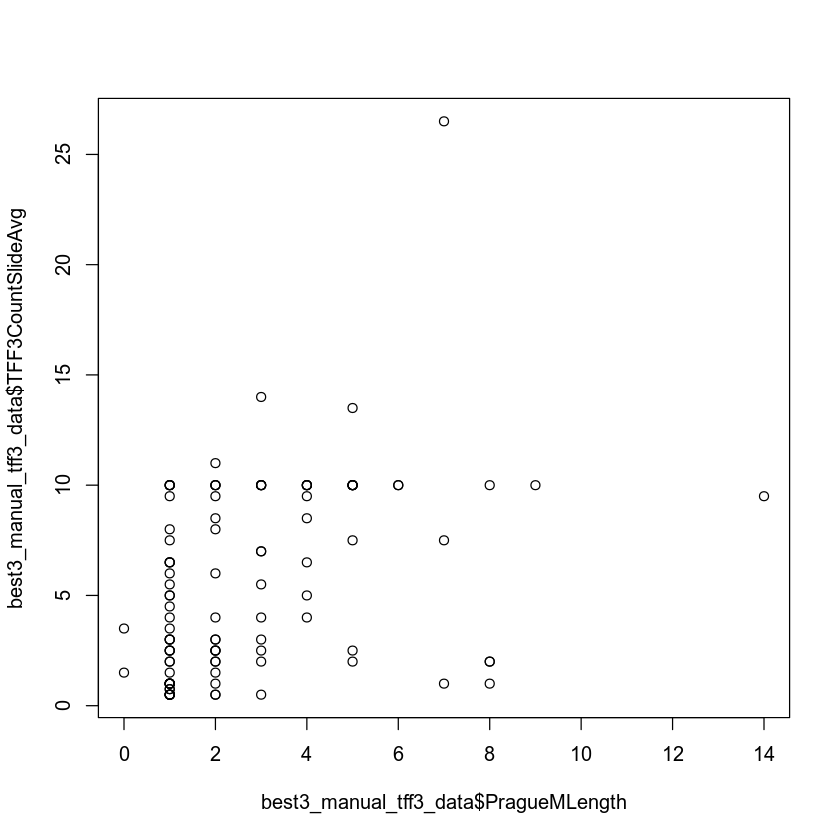

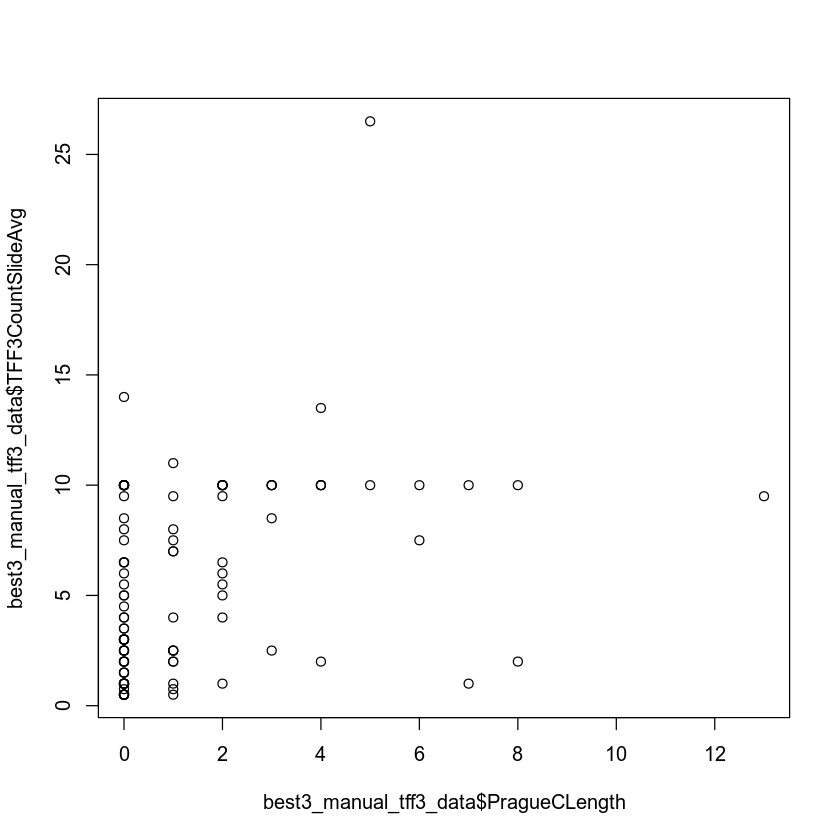

In [6]:
plot(best3_manual_tff3_data$PragueMLength, best3_manual_tff3_data$TFF3CountSlideAvg)
plot(best3_manual_tff3_data$PragueCLength, best3_manual_tff3_data$TFF3CountSlideAvg)

Merge data appropriately and add new columns for training.

In [7]:
# Merge tile count and Prague length data and perform some cleaning tasks
best2_tff3_prague_data = merge(best2_tff3_tile_data, best2_prague_length_data, by='Case')
best3_tff3_prague_data = merge(best3_tff3_tile_data, best3_prague_length_data, by='Case')
tff3_prague_data = rbind(best2_tff3_prague_data[, c('Case', 'Gastric_count', 'TFF3_positive_count', 'PRAGUE_C', 'PRAGUE_M')],
                            best3_tff3_prague_data[, c('Case', 'Gastric_count', 'TFF3_positive_count', 'PRAGUE_C', 'PRAGUE_M')])
tff3_prague_data$PRAGUE_C <- as.numeric(tff3_prague_data$PRAGUE_C)
tff3_prague_data$PRAGUE_M <- as.numeric(tff3_prague_data$PRAGUE_M)
tff3_prague_data$TFF3_positive_count <- as.numeric(tff3_prague_data$TFF3_positive_count)
tff3_prague_data$Gastric_count <- as.numeric(tff3_prague_data$Gastric_count)


# Add C≥1, C>=2, C>=3, M>=1, M≥3, M>=4, and M>=5 columns
tff3_prague_data$PRAGUE_C_gtet_1cm <- ifelse(tff3_prague_data$PRAGUE_C >= 1, 1, 0)
tff3_prague_data$PRAGUE_C_gtet_2cm <- ifelse(tff3_prague_data$PRAGUE_C >= 2, 1, 0)
tff3_prague_data$PRAGUE_C_gtet_3cm <- ifelse(tff3_prague_data$PRAGUE_C >= 3, 1, 0)
tff3_prague_data$PRAGUE_M_gtet_1cm <- ifelse(tff3_prague_data$PRAGUE_M >= 1, 1, 0)
tff3_prague_data$PRAGUE_M_gtet_3cm <- ifelse(tff3_prague_data$PRAGUE_M >= 3, 1, 0)
tff3_prague_data$PRAGUE_M_gtet_4cm <- ifelse(tff3_prague_data$PRAGUE_M >= 4, 1, 0)
tff3_prague_data$PRAGUE_M_gtet_5cm <- ifelse(tff3_prague_data$PRAGUE_M >= 5, 1, 0)

# Add C>=1 OR M>=1 column, a C≥1 OR M≥3 column, a C≥2 OR M≥4 colum, and a C≥3 OR M≥5 column
tff3_prague_data$C_gtet_1_or_M_gtet_1 <- ifelse(tff3_prague_data$PRAGUE_C >= 1 | tff3_prague_data$PRAGUE_M >= 1, 1, 0)
tff3_prague_data$C_gtet_1_or_M_gtet_3 <- ifelse(tff3_prague_data$PRAGUE_C >= 1 | tff3_prague_data$PRAGUE_M >= 3, 1, 0)
tff3_prague_data$C_gtet_2_or_M_gtet_4 <- ifelse(tff3_prague_data$PRAGUE_C >= 2 | tff3_prague_data$PRAGUE_M >= 4, 1, 0)
tff3_prague_data$C_gtet_3_or_M_gtet_5 <- ifelse(tff3_prague_data$PRAGUE_C >= 3 | tff3_prague_data$PRAGUE_M >= 5, 1, 0)



# Create doubled C and M columns to have only integer values for Poisson regression models
tff3_prague_data$PRAGUE_M_doubled <- tff3_prague_data$PRAGUE_M * 2
tff3_prague_data$PRAGUE_C_doubled <- tff3_prague_data$PRAGUE_C * 2

# Re-split data into BEST2 and BEST3 pieces
best2_tff3_prague_data <- head(tff3_prague_data, nrow(best2_tff3_prague_data))
best3_tff3_prague_data <- tail(tff3_prague_data, nrow(best3_tff3_prague_data))

# Convert to data.table
best2_tff3_prague_data <- setDT(best2_tff3_prague_data)
best3_tff3_prague_data <- setDT(best3_tff3_prague_data)
tff3_prague_data <- setDT(tff3_prague_data)


# Create versions of the above data tables with no patients with no patients with TFF3 positive tile counts of 0
best2_tff3_prague_data_nozeros <- best2_tff3_prague_data[best2_tff3_prague_data$TFF3_positive_count != 0,]
best3_tff3_prague_data_nozeros <- best3_tff3_prague_data[best3_tff3_prague_data$TFF3_positive_count != 0,]
tff3_prague_data_nozeros <- tff3_prague_data[tff3_prague_data$TFF3_positive_count != 0,]

Show how many patients have long segments by diagnostic criteria in BEST2 and BEST3.

In [8]:
print(paste0("BEST2 long segment patients: ", sum(best2_tff3_prague_data$C_gtet_1_or_M_gtet_3)))
print(paste0("BEST3 long segment patients: ", sum(best3_tff3_prague_data$C_gtet_1_or_M_gtet_3)))
print(paste0("Total BEST2 patients: ", nrow(best2_tff3_prague_data)))
print(paste0("Total BEST3 patients: ", nrow(best3_tff3_prague_data)))

[1] "BEST2 long segment patients: 315"
[1] "BEST3 long segment patients: 47"
[1] "Total BEST2 patients: 529"
[1] "Total BEST3 patients: 158"


Compute Spearman's correlation coefficients.

In [9]:
# correlation metrics
print('Prague C ~ TFF3 positive tile count Spearman rho')
cor(best2_tff3_prague_data$TFF3_positive_count, best2_tff3_prague_data$PRAGUE_C, method = c("spearman"))
print('Prague M ~ TFF3 positive tile count Spearman rho')
cor(best2_tff3_prague_data$TFF3_positive_count, best2_tff3_prague_data$PRAGUE_M, method = c("spearman"))
print('Prague C ~ Gastric tile count Spearman rho')
cor(best2_tff3_prague_data$Gastric_count, best2_tff3_prague_data$PRAGUE_C, method = c("spearman"))
print('Prague M ~ Gastric tile count Spearman rho')
cor(best2_tff3_prague_data$Gastric_count, best2_tff3_prague_data$PRAGUE_M, method = c("spearman"))

[1] "Prague C ~ TFF3 positive tile count Spearman rho"


[1] 0.7317658

[1] "Prague M ~ TFF3 positive tile count Spearman rho"


[1] 0.7728281

[1] "Prague C ~ Gastric tile count Spearman rho"


[1] -0.02362228

[1] "Prague M ~ Gastric tile count Spearman rho"


[1] -0.04628601

CLASSIFICATION SECTION

Train 5-fold cross validation logistic regression models for predicting segment length class: (C≥1 OR M≥3) vs. (C<1 AND M<3)

In [10]:
# create 5 folds for cross validation across 691 patients from BEST2 and BEST3 
# (138 patients per val fold, 553 per training fold)
set.seed(366)

# For BEST2 only analyses
tff3_prague_data_shuffled <- best2_tff3_prague_data[sample(nrow(best2_tff3_prague_data)),]

# split folds into training and validation components
fold_size = round(nrow(tff3_prague_data_shuffled)/5)
n <- nrow(tff3_prague_data_shuffled)
r  <- rep(1:ceiling(n/fold_size), each=fold_size)[1:n]
d <- split(tff3_prague_data_shuffled, r)
val1 <- d[["1"]]
val2 <- d[["2"]]
val3 <- d[["3"]]
val4 <- d[["4"]]
val5 <- d[["5"]]
train1 <- rbind(val2, val3, val4, val5)
train2 <- rbind(val1, val3, val4, val5)
train3 <- rbind(val1, val2, val4, val5)
train4 <- rbind(val1, val2, val3, val5)
train5 <- rbind(val1, val2, val3, val4)

# 5-fold classification models trained on training components (C>=1 or M>=3)
logreg_c_gtet_1cm_or_m_gtet_1cm_1 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_1cm_or_m_gtet_1cm_2 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_1cm_or_m_gtet_1cm_3 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_1cm_or_m_gtet_1cm_4 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_1cm_or_m_gtet_1cm_5 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=1 or M>=3)
logreg_c_gtet_1cm_or_m_gtet_3cm_1 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_1cm_or_m_gtet_3cm_2 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_1cm_or_m_gtet_3cm_3 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_1cm_or_m_gtet_3cm_4 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_1cm_or_m_gtet_3cm_5 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=2 or M>=4)
logreg_c_gtet_2cm_or_m_gtet_4cm_1 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_2cm_or_m_gtet_4cm_2 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_2cm_or_m_gtet_4cm_3 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_2cm_or_m_gtet_4cm_4 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_2cm_or_m_gtet_4cm_5 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=3 or M>=5)
logreg_c_gtet_3cm_or_m_gtet_5cm_1 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_3cm_or_m_gtet_5cm_2 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_3cm_or_m_gtet_5cm_3 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_3cm_or_m_gtet_5cm_4 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_3cm_or_m_gtet_5cm_5 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=1)
logreg_c_gtet_1cm_1 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_1cm_2 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_1cm_3 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_1cm_4 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_1cm_5 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=2)
logreg_c_gtet_2cm_1 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_2cm_2 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_2cm_3 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_2cm_4 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_2cm_5 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (C>=3)
logreg_c_gtet_3cm_1 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_3cm_2 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_3cm_3 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_3cm_4 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_3cm_5 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (M>=1)
logreg_m_gtet_1cm_1 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_m_gtet_1cm_2 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_m_gtet_1cm_3 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_m_gtet_1cm_4 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_m_gtet_1cm_5 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (M>=3)
logreg_m_gtet_3cm_1 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_m_gtet_3cm_2 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_m_gtet_3cm_3 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_m_gtet_3cm_4 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_m_gtet_3cm_5 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (M>=4)
logreg_m_gtet_4cm_1 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_m_gtet_4cm_2 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_m_gtet_4cm_3 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_m_gtet_4cm_4 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_m_gtet_4cm_5 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = train5)

# 5-fold classification models trained on training components (M>=5)
logreg_m_gtet_5cm_1 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train1)
logreg_m_gtet_5cm_2 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train2)
logreg_m_gtet_5cm_3 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train3)
logreg_m_gtet_5cm_4 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train4)
logreg_m_gtet_5cm_5 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = train5)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning mess

We can now evalute model performance on validation component of each fold. Let's first define performance metric functions.

In [58]:
get_balanced_accuracy <- function(data, indices){
    d <- data[indices,]
    bal_acc <- bal_accuracy_vec(factor(d[["y_actual"]]), factor(ifelse(d[["y_predict"]] >= 0.5, 1, 0)))
    bal_acc
}
get_precision_long <- function(data, indices){
    d <- data[indices,]
    prec_long <- Precision(d[["y_actual"]], ifelse(d[["y_predict"]] >= 0.5, 1, 0), positive=1)
    prec_long
}
get_precision_short <- function(data, indices){
    d <- data[indices,]
    prec_short <- Precision(d[["y_actual"]], ifelse(d[["y_predict"]] >= 0.5, 1, 0), positive=0)
    prec_short
}
get_recall_long <- function(data, indices){
    d <- data[indices,]
    rec_long <- Recall(d[["y_actual"]], ifelse(d[["y_predict"]] >= 0.5, 1, 0), positive=1)
    rec_long
}
get_recall_short <- function(data, indices){
    d <- data[indices,]
    rec_short <- Recall(d[["y_actual"]], ifelse(d[["y_predict"]] >= 0.5, 1, 0), positive=0)
    rec_short
}
get_f1_long <- function(data, indices){
    d <- data[indices,]
    f1_long <- F1_Score(d[["y_actual"]], ifelse(d[["y_predict"]] >= 0.5, 1, 0), positive=1)
    f1_long
}
get_f1_short <- function(data, indices){
    d <- data[indices,]
    f1_short <- F1_Score(d[["y_actual"]], ifelse(d[["y_predict"]] >= 0.5, 1, 0), positive=0)
    f1_short
}

bootstrap_stat <- function(y_actual, y_predict, stat, replicates=1000){
    ap_df <- data.frame("y_actual"=y_actual, "y_predict"=y_predict)
    if (stat=='bal_acc') {
        bootstrap_results <- boot(ap_df, R=replicates, statistic=get_balanced_accuracy)
    } else if (stat=='prec_long'){
        bootstrap_results <- boot(ap_df, R=replicates, statistic=get_precision_long)
    } else if (stat=='prec_short'){
        bootstrap_results <- boot(ap_df, R=replicates, statistic=get_precision_short)
    } else if (stat=='rec_long'){
        bootstrap_results <- boot(ap_df, R=replicates, statistic=get_recall_long)
    } else if (stat=='rec_short'){
        bootstrap_results <- boot(ap_df, R=replicates, statistic=get_recall_short)
    } else if (stat=='f1_long'){
        bootstrap_results <- boot(ap_df, R=replicates, statistic=get_f1_long)
    } else if (stat=='f1_short'){
        bootstrap_results <- boot(ap_df, R=replicates, statistic=get_f1_short)
    } else{
        stop("stat must be one of: bal_acc, prec_long, prec_short, rec_long, rec_short, f1_long, f1_short")
    }
    bootstrap_ci <- boot.ci(bootstrap_results, type="perc")
    bootstrap_ci
}

RSQUARE = function(y_actual,y_predict){
  cor(y_actual,y_predict)^2
}
RMSE = function(y_actual, y_predict){
    sqrt(mean((y_predict - y_actual)^2))
}
METRIFY = function(y_actual, y_predict, model){
    acc = Accuracy(ifelse(y_predict >= 0.5, 1, 0), y_actual)
    acc_balanced = bal_accuracy_vec(factor(y_actual), factor(ifelse(y_predict >= 0.5, 1, 0)))
    prec_long = Precision(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=1)
    prec_short = Precision(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=0)
    rec_long = Recall(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=1)
    rec_short = Recall(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=0)
    f1_long = F1_Score(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=1)
    f1_short = F1_Score(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=0)
    tile_cutoff = unname(dose.p(model, p=0.5)[1])
    tile_cutoff_se = unname(attr(dose.p(model, p=0.5), "SE"))
    
    acc_balanced_ci = bootstrap_stat(y_actual, y_predict, "bal_acc", replicates=500)
    prec_long_ci = bootstrap_stat(y_actual, y_predict, "prec_long", replicates=500)
    prec_short_ci = bootstrap_stat(y_actual, y_predict, "prec_short", replicates=500)
    rec_long_ci = bootstrap_stat(y_actual, y_predict, "rec_long", replicates=500)
    rec_short_ci = bootstrap_stat(y_actual, y_predict, "rec_short", replicates=500)
    f1_long_ci = bootstrap_stat(y_actual, y_predict, "f1_long", replicates=500)
    f1_short_ci = bootstrap_stat(y_actual, y_predict, "f1_short", replicates=500)
    
    list(Accuracy=acc, Balanced_acc=acc_balanced, Balanced_acc_CI_low=acc_balanced_ci$percent[4], Balanced_acc_CI_high=acc_balanced_ci$percent[5], 
         Precision_long=prec_long, Precision_long_CI_low=prec_long_ci$percent[4], Precision_long_CI_high=prec_long_ci$percent[5], 
         Precision_short=prec_short, Precision_short_CI_low=prec_short_ci$percent[4], Precision_short_CI_high=prec_short_ci$percent[5],
         Recall_long=rec_long, Recall_long_CI_low=rec_long_ci$percent[4], Recall_long_CI_high=rec_long_ci$percent[5], 
         Recall_short=rec_short, Recall_short_CI_low=rec_short_ci$percent[4], Recall_short_CI_high=rec_short_ci$percent[5],
         F1_long=f1_long, F1_long_CI_low=f1_long_ci$percent[4], F1_long_CI_high=f1_long_ci$percent[5], 
         F1_short=f1_short, F1_short_CI_low=f1_short_ci$percent[4], F1_short_CI_high=f1_short_ci$percent[5], 
         Tile_cutoff=tile_cutoff, Tile_cutoff_SE=tile_cutoff_se)
}

Get classification predictions for each fold on validation components

In [12]:
# C>=1 or M>=1
logreg_c_gtet_1cm_or_m_gtet_1cm_1_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_1cm_2_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_1cm_3_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_1cm_4_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_1cm_5_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=1 or M>=3
logreg_c_gtet_1cm_or_m_gtet_3cm_1_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_2_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_3_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_4_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_5_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=2 or M>=4
logreg_c_gtet_2cm_or_m_gtet_4cm_1_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_or_m_gtet_4cm_2_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_or_m_gtet_4cm_3_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_or_m_gtet_4cm_4_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_or_m_gtet_4cm_5_pred <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=3 or M>=5
logreg_c_gtet_3cm_or_m_gtet_5cm_1_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_or_m_gtet_5cm_2_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_or_m_gtet_5cm_3_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_or_m_gtet_5cm_4_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_or_m_gtet_5cm_5_pred <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=1
logreg_c_gtet_1cm_1_pred <- predict(logreg_c_gtet_1cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_2_pred <- predict(logreg_c_gtet_1cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_3_pred <- predict(logreg_c_gtet_1cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_4_pred <- predict(logreg_c_gtet_1cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_5_pred <- predict(logreg_c_gtet_1cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=2
logreg_c_gtet_2cm_1_pred <- predict(logreg_c_gtet_2cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_2_pred <- predict(logreg_c_gtet_2cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_3_pred <- predict(logreg_c_gtet_2cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_4_pred <- predict(logreg_c_gtet_2cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_2cm_5_pred <- predict(logreg_c_gtet_2cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# C>=3
logreg_c_gtet_3cm_1_pred <- predict(logreg_c_gtet_3cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_2_pred <- predict(logreg_c_gtet_3cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_3_pred <- predict(logreg_c_gtet_3cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_4_pred <- predict(logreg_c_gtet_3cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_3cm_5_pred <- predict(logreg_c_gtet_3cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# M>=1
logreg_m_gtet_1cm_1_pred <- predict(logreg_m_gtet_1cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_m_gtet_1cm_2_pred <- predict(logreg_m_gtet_1cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_m_gtet_1cm_3_pred <- predict(logreg_m_gtet_1cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_m_gtet_1cm_4_pred <- predict(logreg_m_gtet_1cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_m_gtet_1cm_5_pred <- predict(logreg_m_gtet_1cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# M>=3
logreg_m_gtet_3cm_1_pred <- predict(logreg_m_gtet_3cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_m_gtet_3cm_2_pred <- predict(logreg_m_gtet_3cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_m_gtet_3cm_3_pred <- predict(logreg_m_gtet_3cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_m_gtet_3cm_4_pred <- predict(logreg_m_gtet_3cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_m_gtet_3cm_5_pred <- predict(logreg_m_gtet_3cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# M>=4
logreg_m_gtet_4cm_1_pred <- predict(logreg_m_gtet_4cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_m_gtet_4cm_2_pred <- predict(logreg_m_gtet_4cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_m_gtet_4cm_3_pred <- predict(logreg_m_gtet_4cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_m_gtet_4cm_4_pred <- predict(logreg_m_gtet_4cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_m_gtet_4cm_5_pred <- predict(logreg_m_gtet_4cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# M>=5
logreg_m_gtet_5cm_1_pred <- predict(logreg_m_gtet_5cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_m_gtet_5cm_2_pred <- predict(logreg_m_gtet_5cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_m_gtet_5cm_3_pred <- predict(logreg_m_gtet_5cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_m_gtet_5cm_4_pred <- predict(logreg_m_gtet_5cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_m_gtet_5cm_5_pred <- predict(logreg_m_gtet_5cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

Get performance metric results

In [59]:
# C>=1 or M>=1
fold1_c1m1 = METRIFY(val1$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_1_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_1)
fold2_c1m1 = METRIFY(val2$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_2_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_2)
fold3_c1m1 = METRIFY(val3$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_3_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_3)
fold4_c1m1 = METRIFY(val4$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_4_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_4)
fold5_c1m1 = METRIFY(val5$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_5_pred, logreg_c_gtet_1cm_or_m_gtet_1cm_5)

# C>=1 or M>=3
fold1_c1m3 = METRIFY(val1$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_1_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_1)
fold2_c1m3 = METRIFY(val2$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_2_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_2)
fold3_c1m3 = METRIFY(val3$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_3_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_3)
fold4_c1m3 = METRIFY(val4$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_4_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_4)
fold5_c1m3 = METRIFY(val5$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_5_pred, logreg_c_gtet_1cm_or_m_gtet_3cm_5)

# C>=2 or M>=4
fold1_c2m4 = METRIFY(val1$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_1_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_1)
fold2_c2m4 = METRIFY(val2$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_2_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_2)
fold3_c2m4 = METRIFY(val3$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_3_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_3)
fold4_c2m4 = METRIFY(val4$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_4_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_4)
fold5_c2m4 = METRIFY(val5$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_5_pred, logreg_c_gtet_2cm_or_m_gtet_4cm_5)

# C>=3 or M>=5
fold1_c3m5 = METRIFY(val1$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_1_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_1)
fold2_c3m5 = METRIFY(val2$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_2_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_2)
fold3_c3m5 = METRIFY(val3$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_3_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_3)
fold4_c3m5 = METRIFY(val4$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_4_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_4)
fold5_c3m5 = METRIFY(val5$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_5_pred, logreg_c_gtet_3cm_or_m_gtet_5cm_5)

# C>=1
fold1_c1 = METRIFY(val1$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_1_pred, logreg_c_gtet_1cm_1)
fold2_c1 = METRIFY(val2$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_2_pred, logreg_c_gtet_1cm_2)
fold3_c1 = METRIFY(val3$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_3_pred, logreg_c_gtet_1cm_3)
fold4_c1 = METRIFY(val4$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_4_pred, logreg_c_gtet_1cm_4)
fold5_c1 = METRIFY(val5$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_5_pred, logreg_c_gtet_1cm_5)

# C>=2
fold1_c2 = METRIFY(val1$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_1_pred, logreg_c_gtet_2cm_1)
fold2_c2 = METRIFY(val2$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_2_pred, logreg_c_gtet_2cm_2)
fold3_c2 = METRIFY(val3$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_3_pred, logreg_c_gtet_2cm_3)
fold4_c2 = METRIFY(val4$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_4_pred, logreg_c_gtet_2cm_4)
fold5_c2 = METRIFY(val5$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_5_pred, logreg_c_gtet_2cm_5)

# C>=3
fold1_c3 = METRIFY(val1$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_1_pred, logreg_c_gtet_3cm_1)
fold2_c3 = METRIFY(val2$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_2_pred, logreg_c_gtet_3cm_2)
fold3_c3 = METRIFY(val3$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_3_pred, logreg_c_gtet_3cm_3)
fold4_c3 = METRIFY(val4$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_4_pred, logreg_c_gtet_3cm_4)
fold5_c3 = METRIFY(val5$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_5_pred, logreg_c_gtet_3cm_5)

# M>=1
fold1_m1 = METRIFY(val1$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_1_pred, logreg_m_gtet_1cm_1)
fold2_m1 = METRIFY(val2$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_2_pred, logreg_m_gtet_1cm_2)
fold3_m1 = METRIFY(val3$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_3_pred, logreg_m_gtet_1cm_3)
fold4_m1 = METRIFY(val4$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_4_pred, logreg_m_gtet_1cm_4)
fold5_m1 = METRIFY(val5$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_5_pred, logreg_m_gtet_1cm_5)

# M>=3
fold1_m3 = METRIFY(val1$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_1_pred, logreg_m_gtet_3cm_1)
fold2_m3 = METRIFY(val2$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_2_pred, logreg_m_gtet_3cm_2)
fold3_m3 = METRIFY(val3$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_3_pred, logreg_m_gtet_3cm_3)
fold4_m3 = METRIFY(val4$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_4_pred, logreg_m_gtet_3cm_4)
fold5_m3 = METRIFY(val5$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_5_pred, logreg_m_gtet_3cm_5)

# M>=4
fold1_m4 = METRIFY(val1$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_1_pred, logreg_m_gtet_4cm_1)
fold2_m4 = METRIFY(val2$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_2_pred, logreg_m_gtet_4cm_2)
fold3_m4 = METRIFY(val3$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_3_pred, logreg_m_gtet_4cm_3)
fold4_m4 = METRIFY(val4$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_4_pred, logreg_m_gtet_4cm_4)
fold5_m4 = METRIFY(val5$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_5_pred, logreg_m_gtet_4cm_5)

# M>=5
fold1_m5 = METRIFY(val1$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_1_pred, logreg_m_gtet_5cm_1)
fold2_m5 = METRIFY(val2$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_2_pred, logreg_m_gtet_5cm_2)
fold3_m5 = METRIFY(val3$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_3_pred, logreg_m_gtet_5cm_3)
fold4_m5 = METRIFY(val4$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_4_pred, logreg_m_gtet_5cm_4)
fold5_m5 = METRIFY(val5$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_5_pred, logreg_m_gtet_5cm_5)

[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to  1 \n Cannot calculate confidence intervals"


ERROR: Error in FUN(X[[i]], ...): only defined on a data frame with all numeric variables


Print results

In [60]:
# C>=1 or M>=1 
results = rbindlist(list(fold1_c1m1, fold2_c1m1, fold3_c1m1, fold4_c1m1, fold5_c1m1))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=1cm or M>=1cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=1cm or M>=1cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.7924528 0.8143896    0.7400979           0.8860967           
2 0.8773585 0.8786657    0.8073782           0.9418496           
3 0.8113208 0.8559966    0.7986160           0.9117647           
4 0.7924528 0.8475275    0.7843817           0.9079687           
5 0.8571429 0.8517873    0.7727559           0.9245014           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 0.9245283      0.8404849             0.9824561              0.6603774      
2 0.9152542      0.8347906             0.9805283              0.8297872      
3 0.9821429      0.9412308             1.0000000              0.6200000      
4 0.9827586      0.9388334             1.0000000              0.5625000      
5 0.9275362      0.8630137             0.9848485              0.7222222      
  Precision_short_CI_low Precision_short_CI_high ... Recall_short_CI_low
1 0.5200000              0.7893300               ... 0.7887294          
2 0.6991195              0.9354301               ... 0.7961199          
3 0.4687799              0.7551020               ... 0.9062500          
4 0.4255319              0.7045455               ... 0.8868947          
5 0.5696269              0.8586932               ... 0.6940915          
  Recall_short_CI_high F1_long   F1_long_CI_low F1_long_CI_high F1_short 
1 0.9761905            0.8166667 0.7288980      0.8871534       0.7608696
2 0.9736842            0.8925620 0.8226722      0.9469399       0.8571429
3 1.0000000            0.8461538 0.7808943      0.9057466       0.7560976
4 1.0000000            0.8382353 0.7668003      0.9014085       0.7105263
5 0.9642857            0.8951049 0.8368794      0.9419791       0.7761194
  F1_short_CI_low F1_short_CI_high Tile_cutoff Tile_cutoff_SE
1 0.6509013       0.8421053        6.123937    2.402157      
2 0.7757843       0.9326429        4.632022    0.746372      
3 0.6250457       0.8502682        7.806023    2.398120      
4 0.5649877       0.8152696        7.499915    2.213443      
5 0.6466365       0.8800000        6.275538    2.325775

[1] "Means:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
              0.8261456               0.8496733               0.7806459 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
              0.9144362               0.9464440               0.8836707 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
              0.9895666               0.6789774               0.5366116 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
              0.8086202               0.7882377               0.6884223 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
              0.8811082               0.9111090               0.8144171 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
              0.9828321               0.8577445               0.7872289 
        F1_long_CI_high                F1_short         F1_short_CI_low 
              0.9166455               0.7721511               0.6526711 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
              0.8640572               6.4674871               2.0171733

[1] "Standard deviations:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
            0.038967203             0.023100631             0.026257815 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
            0.020645194             0.033180427             0.052528761 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
            0.009646531             0.102475608             0.105729160 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
            0.090354743             0.072938472             0.085179480 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
            0.056429093             0.055206876             0.085380290 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
            0.016288317             0.034678513             0.043535449 
        F1_long_CI_high                F1_short         F1_short_CI_low 
            0.026364177             0.053436760             0.076889477 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
            0.044750483             1.263070469             0.714497265

In [61]:
# C>=1 or M>=3 
results = rbindlist(list(fold1_c1m3, fold2_c1m3, fold3_c1m3, fold4_c1m3, fold5_c1m3))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=1cm or M>=3cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

Warning message in rbindlist(list(fold1_c1m3, fold2_c1m3, fold3_c1m3, fold4_c1m3, :
“Column 6 ['Precision_long_CI_low'] of item 3 is length 0. This (and 3 others like it) has been filled with NA (NULL for list columns) to make each item uniform.”

[1] "Logistic regression C>=1cm or M>=3cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.8018868 0.8224638    0.7577648           0.8826383           
2 0.8584906 0.8641246    0.7942277           0.9255594           
3 0.7641509 0.8106061    0.7461581           0.8768695           
4 0.7830189 0.8015691    0.7203045           0.8756711           
5 0.8666667 0.8778846    0.8135459           0.9401313           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 0.9756098      0.9250783             1.00                   0.6923077      
2 0.9375000      0.8571429             1.00                   0.7931034      
3 1.0000000             NA               NA                   0.6153846      
4 0.9074074      0.8163265             0.98                   0.6538462      
5 0.9473684      0.8796782             1.00                   0.7708333      
  Precision_short_CI_low Precision_short_CI_high ... Recall_short_CI_low
1 0.5588235              0.7878788               ... 0.9270658          
2 0.6843210              0.8879331               ... 0.8645688          
3 0.4928645              0.7362820               ...        NA          
4 0.5099162              0.7808484               ... 0.7500000          
5 0.6437037              0.8884847               ... 0.8262186          
  Recall_short_CI_high F1_long   F1_long_CI_low F1_long_CI_high F1_short 
1 1.0000000            0.7920792 0.6995469      0.8743527       0.8108108
2 1.0000000            0.8571429 0.7803544      0.9229667       0.8598131
3        NA            0.7663551 0.6666667      0.8595041       0.7619048
4 0.9725726            0.8099174 0.7219550      0.8832866       0.7472527
5 1.0000000            0.8852459 0.8165079      0.9365079       0.8409091
  F1_short_CI_low F1_short_CI_high Tile_cutoff Tile_cutoff_SE
1 0.7264409       0.8869565        17.80157    3.489401      
2 0.7715531       0.9230769        13.33450    2.040552      
3 0.6598936       0.8519396        20.13999    3.658029      
4 0.6285714       0.8385116        15.98679    2.629123      
5 0.7581331       0.9161785        16.42950    3.132873

[1] "Means:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
              0.8148428               0.8353296               0.7664002 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
              0.9001739               0.9535771               0.8695565 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
              0.9950000               0.7050950               0.5779258 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
              0.8162854               0.7278930               0.6249431 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
              0.8316305               0.9427663               0.8419633 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
              0.9931431               0.8221481               0.7370062 
        F1_long_CI_high                F1_short         F1_short_CI_low 
              0.8953236               0.8041381               0.7089184 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
              0.8833326              16.7384700               2.9899954

[1] "Standard deviations:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
             0.04566488              0.03375143              0.03743733 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
             0.03038089              0.03559910                      NA 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
                     NA              0.07567187              0.08347502 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
             0.06857368              0.08590267              0.09284525 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
             0.07200861              0.04975960                      NA 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
                     NA              0.04840596              0.06078030 
        F1_long_CI_high                F1_short         F1_short_CI_low 
             0.03289374              0.04877482              0.06227217 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
             0.03763656              2.49739729              0.66101463

In [62]:
# C>=2 or M>=4 
results = rbindlist(list(fold1_c2m4, fold2_c2m4, fold3_c2m4, fold4_c2m4, fold5_c2m4))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=2cm or M>=4cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=2cm or M>=4cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.7641509 0.7388335    0.6582386           0.8183556           
2 0.7547170 0.7399425    0.6505350           0.8124964           
3 0.7358491 0.7440285    0.6725149           0.8147279           
4 0.8490566 0.8472222    0.7810557           0.9114630           
5 0.7428571 0.7723547    0.7000258           0.8390011           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 0.7647059      0.6000000             0.9067820              0.7638889      
2 0.8235294      0.6842105             0.9530433              0.7222222      
3 0.9354839      0.8400000             1.0000000              0.6533333      
4 0.9285714      0.8378378             1.0000000              0.7968750      
5 0.9473684      0.8515687             1.0000000              0.6268657      
  Precision_short_CI_low Precision_short_CI_high ... Recall_short_CI_low
1 0.6569439              0.8609236               ... 0.7848896          
2 0.6192698              0.8266667               ... 0.8113208          
3 0.5320840              0.7717586               ... 0.9000000          
4 0.6880746              0.8880542               ... 0.8801122          
5 0.5147059              0.7273275               ... 0.8823529          
  Recall_short_CI_high F1_long   F1_long_CI_low F1_long_CI_high F1_short 
1 0.9530647            0.6753247 0.5481809      0.7882771       0.8148148
2 0.9639394            0.6829268 0.5526316      0.7792208       0.8000000
3 1.0000000            0.6744186 0.5290963      0.7803353       0.7777778
4 1.0000000            0.8297872 0.7356322      0.9025511       0.8644068
5 1.0000000            0.7272727 0.6047201      0.8284470       0.7567568
  F1_short_CI_low F1_short_CI_high Tile_cutoff Tile_cutoff_SE
1 0.7319807       0.8771722        39.68862    5.338240      
2 0.7097721       0.8767456        38.08739    4.821616      
3 0.6891276       0.8539357        50.67257    6.590058      
4 0.7904180       0.9278788        43.57168    6.183573      
5 0.6640303       0.8411215        50.75117    6.938955

[1] "Means:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
              0.7693261               0.7684763               0.6924740 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
              0.8392088               0.8799318               0.7627234 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
              0.9719651               0.7126370               0.6022156 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
              0.8149461               0.6110842               0.4696544 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
              0.7399980               0.9258684               0.8517351 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
              0.9834008               0.7179460               0.5940522 
        F1_long_CI_high                F1_short         F1_short_CI_low 
              0.8157663               0.8027512               0.7170657 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
              0.8753708              44.5542860               5.9744884

[1] "Standard deviations:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
             0.04587614              0.04611542              0.05299307 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
             0.04173860              0.08132925              0.11418244 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
             0.04172750              0.07191717              0.07621382 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
             0.06545660              0.08302276              0.09213144 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
             0.07299081              0.03885686              0.05043275 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
             0.02305226              0.06620612              0.08396103 
        F1_long_CI_high                F1_short         F1_short_CI_low 
             0.05253329              0.04090743              0.04808719 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
             0.03314626              5.96438846              0.87845966

In [63]:
# C>=3 or M>=5 
results = rbindlist(list(fold1_c3m5, fold2_c3m5, fold3_c3m5, fold4_c3m5, fold5_c3m5))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=3cm or M>=5cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=3cm or M>=5cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.8207547 0.7287256    0.6440850           0.8151546           
2 0.8396226 0.7810458    0.7009902           0.8642996           
3 0.6415094 0.6059626    0.5450263           0.6740640           
4 0.8018868 0.7522727    0.6692632           0.8347681           
5 0.7238095 0.6995598    0.6211395           0.7827422           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 0.8888889      0.7142857             1.0000000              0.8068182      
2 0.8400000      0.6910699             0.9833326              0.8395062      
3 0.9166667      0.7076194             1.0000000              0.6063830      
4 0.8800000      0.7211852             1.0000000              0.7777778      
5 0.8461538      0.6666667             0.9642857              0.6835443      
  Precision_short_CI_low Precision_short_CI_high ... Recall_short_CI_low
1 0.7166996              0.8869595               ... 0.9324324          
2 0.7628509              0.9250000               ... 0.8870968          
3 0.5052125              0.7058505               ... 0.9428883          
4 0.6892063              0.8640650               ... 0.9015316          
5 0.5776645              0.7872896               ... 0.8431373          
  Recall_short_CI_high F1_long   F1_long_CI_low F1_long_CI_high F1_short 
1 1.0000000            0.6274510 0.4234417      0.7619048       0.8819876
2 0.9865706            0.7118644 0.5473560      0.8347474       0.8888889
3 1.0000000            0.3666667 0.2000000      0.5193712       0.7500000
4 1.0000000            0.6769231 0.5357143      0.7933589       0.8571429
5 0.9837299            0.6027397 0.4539798      0.7174735       0.7883212
  F1_short_CI_low F1_short_CI_high Tile_cutoff Tile_cutoff_SE
1 0.8271605       0.9313343        134.12951   18.68902      
2 0.8351106       0.9348928         91.91892   10.80557      
3 0.6666667       0.8235294        159.50922   20.19925      
4 0.7885405       0.9146343        132.37814   18.54789      
5 0.7131783       0.8553018        141.61527   19.09947

[1] "Means:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
              0.7655166               0.7135133               0.6361008 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
              0.7942057               0.8743419               0.7001654 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
              0.9895237               0.7428059               0.6503268 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
              0.8338329               0.4699495               0.3215522 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
              0.6173596               0.9570771               0.9014173 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
              0.9940601               0.5971290               0.4320984 
        F1_long_CI_high                F1_short         F1_short_CI_low 
              0.7253711               0.8332681               0.7661313 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
              0.8919385             131.9102128              17.4682407

[1] "Standard deviations:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
            0.082132520             0.067186650             0.058933258 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
            0.073421341             0.031658124             0.021804079 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
            0.015847270             0.095909720             0.105967685 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
            0.087455180             0.146990204             0.129239561 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
            0.160133490             0.020885384             0.039634057 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
            0.008195311             0.135642082             0.140039251 
        F1_long_CI_high                F1_short         F1_short_CI_low 
            0.122900917             0.061219006             0.073624228 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
            0.049835354            24.800913716             3.780424536

In [64]:
# C>=1
results = rbindlist(list(fold1_c1, fold2_c1, fold3_c1, fold4_c1, fold5_c1))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=1cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

Warning message in rbindlist(list(fold1_c1, fold2_c1, fold3_c1, fold4_c1, fold5_c1)):
“Column 6 ['Precision_long_CI_low'] of item 1 is length 0. This (and 3 others like it) has been filled with NA (NULL for list columns) to make each item uniform.”

[1] "Logistic regression C>=1cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.7735849 0.7931034    0.7300000           0.8533635           
2 0.7735849 0.7653571    0.6858944           0.8420874           
3 0.7264151 0.7300570    0.6553542           0.8067792           
4 0.7830189 0.7942661    0.7091380           0.8665886           
5 0.7904762 0.8111111    0.7445603           0.8776777           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 1.0000000             NA                    NA              0.6666667      
2 0.8611111      0.7101302             0.9714286              0.7285714      
3 0.8787879      0.7419355             0.9863242              0.6575342      
4 0.8913043      0.7901265             0.9764489              0.7000000      
5 0.9523810      0.8751304             1.0000000              0.6825397      
  Precision_short_CI_low Precision_short_CI_high ... Recall_short_CI_low
1 0.5448890              0.7746479               ...        NA          
2 0.6241546              0.8219178               ... 0.8270719          
3 0.5401710              0.7649831               ... 0.8426557          
4 0.5887955              0.8173737               ... 0.7936870          
5 0.5635169              0.8118449               ... 0.8942143          
  Recall_short_CI_high F1_long   F1_long_CI_low F1_long_CI_high F1_short 
1        NA            0.7391304 0.6233766      0.8306720       0.8000000
2 0.9759543            0.7209302 0.6012687      0.8167361       0.8095238
3 0.9818182            0.6666667 0.5317425      0.7838825       0.7680000
4 0.9629630            0.7809524 0.6858495      0.8619567       0.7850467
5 1.0000000            0.7843137 0.6939323      0.8679245       0.7962963
  F1_short_CI_low F1_short_CI_high Tile_cutoff Tile_cutoff_SE
1 0.7168510       0.8721693        41.26668    6.640244      
2 0.7378537       0.8768099        30.38223    4.877522      
3 0.6786013       0.8477107        35.06632    5.492585      
4 0.6930693       0.8656622        34.05945    5.523742      
5 0.7115409       0.8776463        36.34240    6.100627

[1] "Means:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
              0.7694160               0.7787790               0.7049894 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
              0.8492993               0.9167169               0.7793307 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
              0.9835504               0.6870624               0.5723054 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
              0.7981535               0.6209652               0.4854723 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
              0.7444661               0.9365928               0.8394072 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
              0.9801839               0.7383987               0.6272339 
        F1_long_CI_high                F1_short         F1_short_CI_low 
              0.8322344               0.7917734               0.7075832 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
              0.8679997              35.4234126               5.7269440

[1] "Standard deviations:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
             0.02506196              0.03179775              0.03548543 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
             0.02729810              0.05784551                      NA 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
                     NA              0.02827867              0.03471954 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
             0.02633629              0.06286939              0.06923709 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
             0.05170159              0.04206945                      NA 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
                     NA              0.04839983              0.06650592 
        F1_long_CI_high                F1_short         F1_short_CI_low 
             0.03441565              0.01591880              0.02274018 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
             0.01230010              3.94935870              0.66923253

In [65]:
# C>=2
results = rbindlist(list(fold1_c2, fold2_c2, fold3_c2, fold4_c2, fold5_c2))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=2cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression C>=2cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.7735849 0.7030233    0.6268380           0.7802897           
2 0.7735849 0.7306502    0.6400828           0.8208643           
3 0.6415094 0.6165414    0.5468439           0.6872267           
4 0.8113208 0.7902174    0.7131201           0.8730773           
5 0.7428571 0.7447388    0.6740671           0.8163276           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 0.8947368      0.7305052             1.0000000              0.7471264      
2 0.7333333      0.5789083             0.8907407              0.7894737      
3 0.8235294      0.6153846             1.0000000              0.6067416      
4 0.9062500      0.7967818             1.0000000              0.7702703      
5 0.9062500      0.7836311             1.0000000              0.6712329      
  Precision_short_CI_low Precision_short_CI_high ... Recall_short_CI_low
1 0.6509013              0.8375000               ... 0.9230769          
2 0.7037037              0.8765432               ... 0.7969767          
3 0.5113867              0.7075728               ... 0.8796782          
4 0.6792656              0.8551615               ... 0.8910054          
5 0.5461591              0.7769980               ... 0.8775510          
  Recall_short_CI_high F1_long   F1_long_CI_low F1_long_CI_high F1_short 
1 1.0000000            0.5862069 0.4213400      0.7193333       0.8441558
2 0.9469941            0.6470588 0.5000000      0.7743914       0.8333333
3 1.0000000            0.4242424 0.2570596      0.5713736       0.7397260
4 1.0000000            0.7435897 0.6187518      0.8263575       0.8507463
5 1.0000000            0.6823529 0.5622582      0.7860888       0.7840000
  F1_short_CI_low F1_short_CI_high Tile_cutoff Tile_cutoff_SE
1 0.7779670       0.9005761         99.67602   14.629629     
2 0.7632827       0.8918919         63.38298    7.607368     
3 0.6518665       0.8152866        111.51165   14.863609     
4 0.7876561       0.9102453        103.20940   15.496086     
5 0.6950846       0.8581305        117.60011   17.325635

[1] "Means:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
              0.7485714               0.7170342               0.6401904 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
              0.7955571               0.8528199               0.7010422 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
              0.9781481               0.7169690               0.6182833 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
              0.8107551               0.4956327               0.3420656 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
              0.6365666               0.9384357               0.8736576 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
              0.9893988               0.6166902               0.4718819 
        F1_long_CI_high                F1_short         F1_short_CI_low 
              0.7355089               0.8103923               0.7351714 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
              0.8752261              99.0760339              13.9844657

[1] "Standard deviations:"


Accuracy            Balanced_acc     Balanced_acc_CI_low 
             0.06458280              0.06442793              0.06196419 
   Balanced_acc_CI_high          Precision_long   Precision_long_CI_low 
             0.06901056              0.07516907              0.09887994 
 Precision_long_CI_high         Precision_short  Precision_short_CI_low 
             0.04886227              0.07623861              0.08471746 
Precision_short_CI_high             Recall_long      Recall_long_CI_low 
             0.06855911              0.13729808              0.12749909 
    Recall_long_CI_high            Recall_short     Recall_short_CI_low 
             0.14493636              0.03308906              0.04656874 
   Recall_short_CI_high                 F1_long          F1_long_CI_low 
             0.02370494              0.12176075              0.14074122 
        F1_long_CI_high                F1_short         F1_short_CI_low 
             0.09940532              0.04739458              0.05899792 
       F1_short_CI_high             Tile_cutoff          Tile_cutoff_SE 
             0.03883206             21.14961285              3.71836366

In [66]:
# C>=3
results = rbindlist(list(fold1_c3, fold2_c3, fold3_c3, fold4_c3, fold5_c3))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression C>=3cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

ERROR: Error in rbindlist(list(fold1_c3, fold2_c3, fold3_c3, fold4_c3, fold5_c3)): Item 3 has 16 columns, inconsistent with item 1 which has 24 columns. To fill missing columns use fill=TRUE.


In [67]:
# M>=1
results = rbindlist(list(fold1_m1, fold2_m1, fold3_m1, fold4_m1, fold5_m1))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression M>=1cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression M>=1cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.7924528 0.8143896    0.7396930           0.8796497           
2 0.8773585 0.8786657    0.8099533           0.9429738           
3 0.8113208 0.8559966    0.7921463           0.9130319           
4 0.7924528 0.8475275    0.7879606           0.9017966           
5 0.8571429 0.8517873    0.7682709           0.9306943           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 0.9245283      0.8481537             0.9824561              0.6603774      
2 0.9152542      0.8425063             0.9834608              0.8297872      
3 0.9821429      0.9439553             1.0000000              0.6200000      
4 0.9827586      0.9417798             1.0000000              0.5625000      
5 0.9275362      0.8573672             0.9839651              0.7222222      
  Recall_long Recall_long_CI_low Recall_long_CI_high Recall_short F1_long  
1 0.7313433   0.6313263          0.8307692           0.8974359    0.8166667
2 0.8709677   0.7805307          0.9477919           0.8863636    0.8925620
3 0.7432432   0.6490231          0.8366530           0.9687500    0.8461538
4 0.7307692   0.6232888          0.8297975           0.9642857    0.8382353
5 0.8648649   0.7862222          0.9400250           0.8387097    0.8951049
  F1_short  Tile_cutoff Tile_cutoff_SE
1 0.7608696 6.123937    2.402157      
2 0.8571429 4.632022    0.746372      
3 0.7560976 7.806023    2.398120      
4 0.7105263 7.499915    2.213443      
5 0.7761194 6.275538    2.325775

[1] "Means:"


Accuracy           Balanced_acc    Balanced_acc_CI_low 
             0.8261456              0.8496733              0.7796048 
  Balanced_acc_CI_high         Precision_long  Precision_long_CI_low 
             0.9136293              0.9464440              0.8867525 
Precision_long_CI_high        Precision_short            Recall_long 
             0.9899764              0.6789774              0.7882377 
    Recall_long_CI_low    Recall_long_CI_high           Recall_short 
             0.6940782              0.8770073              0.9111090 
               F1_long               F1_short            Tile_cutoff 
             0.8577445              0.7721511              6.4674871 
        Tile_cutoff_SE 
             2.0171733

[1] "Standard deviations:"


Accuracy           Balanced_acc    Balanced_acc_CI_low 
           0.038967203            0.023100631            0.026784078 
  Balanced_acc_CI_high         Precision_long  Precision_long_CI_low 
           0.024735066            0.033180427            0.051505466 
Precision_long_CI_high        Precision_short            Recall_long 
           0.009166341            0.102475608            0.072938472 
    Recall_long_CI_low    Recall_long_CI_high           Recall_short 
           0.082072332            0.061190010            0.055206876 
               F1_long               F1_short            Tile_cutoff 
           0.034678513            0.053436760            1.263070469 
        Tile_cutoff_SE 
           0.714497265

In [50]:
# M>=3
results = rbindlist(list(fold1_m3, fold2_m3, fold3_m3, fold4_m3, fold5_m3))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression M>=3cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression M>=3cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.8113208 0.8091168    0.7247613           0.8876028           
2 0.8207547 0.8226496    0.7483994           0.8874384           
3 0.7264151 0.7628299    0.6976267           0.8243278           
4 0.7641509 0.7729895    0.7022484           0.8486481           
5 0.8380952 0.8611111    0.7951717           0.9214286           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 0.9000000      0.7929739             0.9780032              0.7575758      
2 0.9069767      0.8048780             0.9899367              0.7619048      
3 0.9714286      0.9017205             1.0000000              0.6056338      
4 0.8541667      0.7477125             0.9484068              0.6896552      
5 0.9791667      0.9347826             1.0000000              0.7192982      
  Recall_long Recall_long_CI_low Recall_long_CI_high Recall_short F1_long  
1 0.6923077   0.5660377          0.8181818           0.9259259    0.7826087
2 0.7222222   0.6018392          0.8382584           0.9230769    0.8041237
3 0.5483871   0.4166669          0.6666667           0.9772727    0.7010309
4 0.6949153   0.5755936          0.8091503           0.8510638    0.7663551
5 0.7460317   0.6229508          0.8442528           0.9761905    0.8468468
  F1_short  Tile_cutoff Tile_cutoff_SE
1 0.8333333 25.35430    3.939992      
2 0.8347826 22.79752    3.199179      
3 0.7478261 32.01544    4.806832      
4 0.7619048 23.76343    3.547918      
5 0.8282828 28.14866    4.411702

[1] "Means:"


Accuracy           Balanced_acc    Balanced_acc_CI_low 
             0.7921473              0.8057394              0.7336415 
  Balanced_acc_CI_high         Precision_long  Precision_long_CI_low 
             0.8738891              0.9223477              0.8364135 
Precision_long_CI_high        Precision_short            Recall_long 
             0.9832693              0.7068135              0.6807728 
    Recall_long_CI_low    Recall_long_CI_high           Recall_short 
             0.5566176              0.7953020              0.9307060 
               F1_long               F1_short            Tile_cutoff 
             0.7801931              0.8012259             26.4158706 
        Tile_cutoff_SE 
             3.9811245

[1] "Standard deviations:"


Accuracy           Balanced_acc    Balanced_acc_CI_low 
            0.04583050             0.03961428             0.03989114 
  Balanced_acc_CI_high         Precision_long  Precision_long_CI_low 
            0.03783213             0.05249206             0.07856658 
Precision_long_CI_high        Precision_short            Recall_long 
            0.02149076             0.06383467             0.07719427 
    Recall_long_CI_low    Recall_long_CI_high           Recall_short 
            0.08136355             0.07332079             0.05162660 
               F1_long               F1_short            Tile_cutoff 
            0.05357091             0.04268111             3.72869232 
        Tile_cutoff_SE 
            0.64575310

In [51]:
# M>=4
results = rbindlist(list(fold1_m4, fold2_m4, fold3_m4, fold4_m4, fold5_m4))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression M>=4cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression M>=4cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.8018868 0.7473485    0.6652463           0.8302493           
2 0.7830189 0.7518939    0.6581022           0.8375826           
3 0.6698113 0.6638177    0.6009877           0.7335264           
4 0.8301887 0.8170290    0.7376812           0.8840343           
5 0.7714286 0.7878289    0.7186318           0.8589666           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 0.9130435      0.7826087             1.0000000              0.7710843      
2 0.7575758      0.6079710             0.9126261              0.7945205      
3 0.9473684      0.8181818             1.0000000              0.6091954      
4 0.8684211      0.7500000             0.9705882              0.8088235      
5 0.9714286      0.9062500             1.0000000              0.6714286      
  Recall_long Recall_long_CI_low Recall_long_CI_high Recall_short F1_long  
1 0.5250000   0.3801861          0.6750000           0.9696970    0.6666667
2 0.6250000   0.4512699          0.7714286           0.8787879    0.6849315
3 0.3461538   0.2177269          0.4679364           0.9814815    0.5070423
4 0.7173913   0.5750000          0.8453253           0.9166667    0.7857143
5 0.5964912   0.4573100          0.7188341           0.9791667    0.7391304
  F1_short  Tile_cutoff Tile_cutoff_SE
1 0.8590604 60.29165    7.463463      
2 0.8345324 49.65496    5.847664      
3 0.7517730 74.03452    8.838432      
4 0.8593750 61.61561    8.053148      
5 0.7966102 74.58965    9.625424

[1] "Means:"


Accuracy           Balanced_acc    Balanced_acc_CI_low 
             0.7712668              0.7535836              0.6761298 
  Balanced_acc_CI_high         Precision_long  Precision_long_CI_low 
             0.8288718              0.8915675              0.7730023 
Precision_long_CI_high        Precision_short            Recall_long 
             0.9766429              0.7310105              0.5620073 
    Recall_long_CI_low    Recall_long_CI_high           Recall_short 
             0.4162986              0.6957049              0.9451599 
               F1_long               F1_short            Tile_cutoff 
             0.6766970              0.8202702             64.0372782 
        Tile_cutoff_SE 
             7.9656263

[1] "Standard deviations:"


Accuracy           Balanced_acc    Balanced_acc_CI_low 
            0.06091125             0.05765786             0.05404806 
  Balanced_acc_CI_high         Precision_long  Precision_long_CI_low 
            0.05726502             0.08432422             0.10914765 
Precision_long_CI_high        Precision_short            Recall_long 
            0.03798511             0.08672259             0.13898171 
    Recall_long_CI_low    Recall_long_CI_high           Recall_short 
            0.13117346             0.14226951             0.04553816 
               F1_long               F1_short            Tile_cutoff 
            0.10575189             0.04606770            10.46473556 
        Tile_cutoff_SE 
            1.43721182

In [52]:
# M>=5
results = rbindlist(list(fold1_m5, fold2_m5, fold3_m5, fold4_m5, fold5_m5))
row.names(results) = list("Fold1", "Fold2", "Fold3", "Fold4", "Fold5")
print('Logistic regression M>=5cm performance on validation folds:')
results
print("Means:")
colMeans(results, na.rm=TRUE)
print("Standard deviations:")
sapply(results, sd)

[1] "Logistic regression M>=5cm performance on validation folds:"


Accuracy  Balanced_acc Balanced_acc_CI_low Balanced_acc_CI_high
1 0.8490566 0.7535088    0.6652003           0.8482067           
2 0.8301887 0.7586996    0.6655515           0.8511282           
3 0.6603774 0.6029144    0.5429864           0.6684626           
4 0.8113208 0.7484520    0.6673964           0.8251257           
5 0.7333333 0.6851088    0.6013175           0.7621256           
  Precision_long Precision_long_CI_low Precision_long_CI_high Precision_short
1 0.8888889      0.7333333             1.0000000              0.8409091      
2 0.7083333      0.5238095             0.8841479              0.8658537      
3 0.9090909      0.7000000             1.0000000              0.6315789      
4 0.9090909      0.7727273             1.0000000              0.7857143      
5 0.8571429      0.6951726             1.0000000              0.7023810      
  Recall_long Recall_long_CI_low Recall_long_CI_high Recall_short F1_long  
1 0.5333333   0.3539532          0.6944444           0.9736842    0.6666667
2 0.6071429   0.4400000          0.7857143           0.9102564    0.6538462
3 0.2222222   0.1122293          0.3436522           0.9836066    0.3571429
4 0.5263158   0.3678332          0.6875000           0.9705882    0.6666667
5 0.4186047   0.2688890          0.5681818           0.9516129    0.5625000
  F1_short  Tile_cutoff Tile_cutoff_SE
1 0.9024390 166.7215    22.24327      
2 0.8875000 105.8656    11.89924      
3 0.7692308 191.6891    23.24246      
4 0.8684211 165.6450    22.39686      
5 0.8082192 168.8066    21.81099

[1] "Means:"


Accuracy           Balanced_acc    Balanced_acc_CI_low 
             0.7768553              0.7097367              0.6284904 
  Balanced_acc_CI_high         Precision_long  Precision_long_CI_low 
             0.7910098              0.8545094              0.6850086 
Precision_long_CI_high        Precision_short            Recall_long 
             0.9768296              0.7652874              0.4615238 
    Recall_long_CI_low    Recall_long_CI_high           Recall_short 
             0.3085809              0.6158985              0.9579497 
               F1_long               F1_short            Tile_cutoff 
             0.5813645              0.8471620            159.7455713 
        Tile_cutoff_SE 
            20.3185641

[1] "Standard deviations:"


Accuracy           Balanced_acc    Balanced_acc_CI_low 
            0.07859169             0.06676410             0.05541687 
  Balanced_acc_CI_high         Precision_long  Precision_long_CI_low 
            0.07730089             0.08443135             0.09531925 
Precision_long_CI_high        Precision_short            Recall_long 
            0.05181061             0.09757643             0.14972209 
    Recall_long_CI_low    Recall_long_CI_high           Recall_short 
            0.12546900             0.17068142             0.02907055 
               F1_long               F1_short            Tile_cutoff 
            0.13270053             0.05640140            31.97265398 
        Tile_cutoff_SE 
            4.73511745

Train a model on all BEST2 data and infer it on BEST3 data.

In [68]:
# C>=1 or M>=1cm

print('Logistic regression C>=1 or M>=1cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_1cm_or_m_gtet_1cm_best2 <- glm(C_gtet_1_or_M_gtet_1 ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_1cm_or_m_gtet_1cm_pred_best3 <- predict(logreg_c_gtet_1cm_or_m_gtet_1cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$C_gtet_1_or_M_gtet_1, logreg_c_gtet_1cm_or_m_gtet_1cm_pred_best3, logreg_c_gtet_1cm_or_m_gtet_1cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_1cm_or_m_gtet_1cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$C_gtet_1_or_M_gtet_1))

[1] "Logistic regression C>=1 or M>=1cm performance on BEST3 test set:"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

$Accuracy
[1] 0.6265823

$Balanced_acc
[1] 0.6021242

$Balanced_acc_CI_low
[1] 0.5273402

$Balanced_acc_CI_high
[1] 0.6646466

$Precision_long
[1] 0.6422018

$Precision_long_CI_low
[1] 0.5582194

$Precision_long_CI_high
[1] 0.739673

$Precision_short
[1] 0.5918367

$Precision_short_CI_low
[1] 0.4600428

$Precision_short_CI_high
[1] 0.7358491

$Recall_long
[1] 0.7777778

$Recall_long_CI_low
[1] 0.6918645

$Recall_long_CI_high
[1] 0.8622701

$Recall_short
[1] 0.4264706

$Recall_short_CI_low
[1] 0.3138877

$Recall_short_CI_high
[1] 0.5312153

$F1_long
[1] 0.7035176

$F1_long_CI_low
[1] 0.6184079

$F1_long_CI_high
[1] 0.7717386

$F1_short
[1] 0.4957265

$F1_short_CI_low
[1] 0.3805851

$F1_short_CI_high
[1] 0.608

$Tile_cutoff
[1] 6.610323

$Tile_cutoff_SE
         [,1]
[1,] 1.785894

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 29 20
         1 39 70
                                          
               Accuracy : 0.6266          
                 95% CI : (0.5462, 0.7021)
    No Information Rate : 0.5696          
    P-Value [Acc > NIR] : 0.08539         
                                          
                  Kappa : 0.2115          
                                          
 Mcnemar's Test P-Value : 0.01911         
                                          
            Sensitivity : 0.4265          
            Specificity : 0.7778          
         Pos Pred Value : 0.5918          
         Neg Pred Value : 0.6422          
             Prevalence : 0.4304          
         Detection Rate : 0.1835          
   Detection Prevalence : 0.3101          
      Balanced Accuracy : 0.6021          
                                          
       'Positive' Class : 0               
                                    

In [69]:
# C>=1 or M>=3cm

print('Logistic regression C>=1 or M>=3cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_1cm_or_m_gtet_3cm_best2 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_1cm_or_m_gtet_3cm_pred_best3 <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_pred_best3, logreg_c_gtet_1cm_or_m_gtet_3cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_1cm_or_m_gtet_3cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$C_gtet_1_or_M_gtet_3))

[1] "Logistic regression C>=1 or M>=3cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

$Accuracy
[1] 0.7468354

$Balanced_acc
[1] 0.7707495

$Balanced_acc_CI_low
[1] 0.6922325

$Balanced_acc_CI_high
[1] 0.8420439

$Precision_long
[1] 0.5492958

$Precision_long_CI_low
[1] 0.4324919

$Precision_long_CI_high
[1] 0.6639315

$Precision_short
[1] 0.908046

$Precision_short_CI_low
[1] 0.848417

$Precision_short_CI_high
[1] 0.9658788

$Recall_long
[1] 0.8297872

$Recall_long_CI_low
[1] 0.7011348

$Recall_long_CI_high
[1] 0.9417043

$Recall_short
[1] 0.7117117

$Recall_short_CI_low
[1] 0.6290178

$Recall_short_CI_high
[1] 0.7886864

$F1_long
[1] 0.6610169

$F1_long_CI_low
[1] 0.5535714

$F1_long_CI_high
[1] 0.7540984

$F1_short
[1] 0.7979798

$F1_short_CI_low
[1] 0.7356322

$F1_short_CI_high
[1] 0.8591473

$Tile_cutoff
[1] 16.69913

$Tile_cutoff_SE
         [,1]
[1,] 2.658796

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 79  8
         1 32 39
                                          
               Accuracy : 0.7468          
                 95% CI : (0.6716, 0.8126)
    No Information Rate : 0.7025          
    P-Value [Acc > NIR] : 0.1281916       
                                          
                  Kappa : 0.472           
                                          
 Mcnemar's Test P-Value : 0.0002762       
                                          
            Sensitivity : 0.7117          
            Specificity : 0.8298          
         Pos Pred Value : 0.9080          
         Neg Pred Value : 0.5493          
             Prevalence : 0.7025          
         Detection Rate : 0.5000          
   Detection Prevalence : 0.5506          
      Balanced Accuracy : 0.7707          
                                          
       'Positive' Class : 0               
                                    

In [47]:
# C>=2 or M>=4cm

print('Logistic regression C>=2cm or M>=4cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_2cm_or_m_gtet_4cm_best2 <- glm(C_gtet_2_or_M_gtet_4 ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_2cm_or_m_gtet_4cm_pred_best3 <- predict(logreg_c_gtet_2cm_or_m_gtet_4cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$C_gtet_2_or_M_gtet_4, logreg_c_gtet_2cm_or_m_gtet_4cm_pred_best3, logreg_c_gtet_2cm_or_m_gtet_4cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_2cm_or_m_gtet_4cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$C_gtet_2_or_M_gtet_4))

[1] "Logistic regression C>=2cm or M>=4cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

$Accuracy
[1] 0.835443

$Balanced_acc
[1] 0.7287273

$Precision_long
[1] 0.6206897

$Precision_short
[1] 0.8837209

$Recall_long
[1] 0.5454545

$Recall_short
[1] 0.912

$F1_long
[1] 0.5806452

$F1_short
[1] 0.8976378

$Tile_cutoff
[1] 44.31886

$Tile_cutoff_SE
         [,1]
[1,] 5.305232

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 114  15
         1  11  18
                                          
               Accuracy : 0.8354          
                 95% CI : (0.7683, 0.8896)
    No Information Rate : 0.7911          
    P-Value [Acc > NIR] : 0.09925         
                                          
                  Kappa : 0.4788          
                                          
 Mcnemar's Test P-Value : 0.55630         
                                          
            Sensitivity : 0.9120          
            Specificity : 0.5455          
         Pos Pred Value : 0.8837          
         Neg Pred Value : 0.6207          
             Prevalence : 0.7911          
         Detection Rate : 0.7215          
   Detection Prevalence : 0.8165          
      Balanced Accuracy : 0.7287          
                                          
       'Positive' Class : 0               
                              

In [48]:
# C>=3 or M>=5cm

print('Logistic regression C>=3 or M>=5cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_3cm_or_m_gtet_5cm_best2 <- glm(C_gtet_3_or_M_gtet_5 ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_3cm_or_m_gtet_5cm_pred_best3 <- predict(logreg_c_gtet_3cm_or_m_gtet_5cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$C_gtet_3_or_M_gtet_5, logreg_c_gtet_3cm_or_m_gtet_5cm_pred_best3, logreg_c_gtet_3cm_or_m_gtet_5cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_3cm_or_m_gtet_5cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$C_gtet_3_or_M_gtet_5))

[1] "Logistic regression C>=3 or M>=5cm performance on BEST3 test set:"


$Accuracy
[1] 0.8670886

$Balanced_acc
[1] 0.6336554

$Precision_long
[1] 0.5833333

$Precision_short
[1] 0.890411

$Recall_long
[1] 0.3043478

$Recall_short
[1] 0.962963

$F1_long
[1] 0.4

$F1_short
[1] 0.9252669

$Tile_cutoff
[1] 131.7122

$Tile_cutoff_SE
         [,1]
[1,] 15.61124

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 130  16
         1   5   7
                                         
               Accuracy : 0.8671         
                 95% CI : (0.804, 0.9158)
    No Information Rate : 0.8544         
    P-Value [Acc > NIR] : 0.3767         
                                         
                  Kappa : 0.3335         
                                         
 Mcnemar's Test P-Value : 0.0291         
                                         
            Sensitivity : 0.9630         
            Specificity : 0.3043         
         Pos Pred Value : 0.8904         
         Neg Pred Value : 0.5833         
             Prevalence : 0.8544         
         Detection Rate : 0.8228         
   Detection Prevalence : 0.9241         
      Balanced Accuracy : 0.6337         
                                         
       'Positive' Class : 0              
                                         

In [49]:
# C>=1cm

print('Logistic regression C>=1cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_1cm_best2 <- glm(PRAGUE_C_gtet_1cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_1cm_pred_best3 <- predict(logreg_c_gtet_1cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_C_gtet_1cm, logreg_c_gtet_1cm_pred_best3, logreg_c_gtet_1cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_1cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_C_gtet_1cm))

[1] "Logistic regression C>=1cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

$Accuracy
[1] 0.7911392

$Balanced_acc
[1] 0.6926204

$Precision_long
[1] 0.625

$Precision_short
[1] 0.8333333

$Recall_long
[1] 0.4878049

$Recall_short
[1] 0.8974359

$F1_long
[1] 0.5479452

$F1_short
[1] 0.8641975

$Tile_cutoff
[1] 35.37149

$Tile_cutoff_SE
         [,1]
[1,] 5.123556

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 105  21
         1  12  20
                                          
               Accuracy : 0.7911          
                 95% CI : (0.7194, 0.8517)
    No Information Rate : 0.7405          
    P-Value [Acc > NIR] : 0.08451         
                                          
                  Kappa : 0.4148          
                                          
 Mcnemar's Test P-Value : 0.16373         
                                          
            Sensitivity : 0.8974          
            Specificity : 0.4878          
         Pos Pred Value : 0.8333          
         Neg Pred Value : 0.6250          
             Prevalence : 0.7405          
         Detection Rate : 0.6646          
   Detection Prevalence : 0.7975          
      Balanced Accuracy : 0.6926          
                                          
       'Positive' Class : 0               
                              

In [50]:
# C>=2cm

print('Logistic regression C>=2cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_2cm_best2 <- glm(PRAGUE_C_gtet_2cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_2cm_pred_best3 <- predict(logreg_c_gtet_2cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_C_gtet_2cm, logreg_c_gtet_2cm_pred_best3, logreg_c_gtet_2cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_2cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_C_gtet_2cm))

[1] "Logistic regression C>=2cm performance on BEST3 test set:"


$Accuracy
[1] 0.8544304

$Balanced_acc
[1] 0.6836407

$Precision_long
[1] 0.6666667

$Precision_short
[1] 0.8785714

$Recall_long
[1] 0.4137931

$Recall_short
[1] 0.9534884

$F1_long
[1] 0.5106383

$F1_short
[1] 0.9144981

$Tile_cutoff
[1] 98.52706

$Tile_cutoff_SE
         [,1]
[1,] 12.36228

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 123  17
         1   6  12
                                          
               Accuracy : 0.8544          
                 95% CI : (0.7896, 0.9054)
    No Information Rate : 0.8165          
    P-Value [Acc > NIR] : 0.12762         
                                          
                  Kappa : 0.4306          
                                          
 Mcnemar's Test P-Value : 0.03706         
                                          
            Sensitivity : 0.9535          
            Specificity : 0.4138          
         Pos Pred Value : 0.8786          
         Neg Pred Value : 0.6667          
             Prevalence : 0.8165          
         Detection Rate : 0.7785          
   Detection Prevalence : 0.8861          
      Balanced Accuracy : 0.6836          
                                          
       'Positive' Class : 0               
                              

In [51]:
# C>=3cm

print('Logistic regression C>=3cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_c_gtet_3cm_best2 <- glm(PRAGUE_C_gtet_3cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_c_gtet_3cm_pred_best3 <- predict(logreg_c_gtet_3cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_C_gtet_3cm, logreg_c_gtet_3cm_pred_best3, logreg_c_gtet_3cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_c_gtet_3cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_C_gtet_3cm))

[1] "Logistic regression C>=3cm performance on BEST3 test set:"


$Accuracy
[1] 0.8797468

$Balanced_acc
[1] 0.593254

$Precision_long
[1] 0.4444444

$Precision_short
[1] 0.9060403

$Recall_long
[1] 0.2222222

$Recall_short
[1] 0.9642857

$F1_long
[1] 0.2962963

$F1_short
[1] 0.9342561

$Tile_cutoff
[1] 197.8464

$Tile_cutoff_SE
         [,1]
[1,] 23.76505

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 135  14
         1   5   4
                                         
               Accuracy : 0.8797         
                 95% CI : (0.8186, 0.926)
    No Information Rate : 0.8861         
    P-Value [Acc > NIR] : 0.65655        
                                         
                  Kappa : 0.2385         
                                         
 Mcnemar's Test P-Value : 0.06646        
                                         
            Sensitivity : 0.9643         
            Specificity : 0.2222         
         Pos Pred Value : 0.9060         
         Neg Pred Value : 0.4444         
             Prevalence : 0.8861         
         Detection Rate : 0.8544         
   Detection Prevalence : 0.9430         
      Balanced Accuracy : 0.5933         
                                         
       'Positive' Class : 0              
                                         

In [52]:
# M>=1cm

print('Logistic regression M>=1cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_m_gtet_1cm_best2 <- glm(PRAGUE_M_gtet_1cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_m_gtet_1cm_pred_best3 <- predict(logreg_m_gtet_1cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_M_gtet_1cm, logreg_m_gtet_1cm_pred_best3, logreg_m_gtet_1cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_m_gtet_1cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_M_gtet_1cm))

[1] "Logistic regression M>=1cm performance on BEST3 test set:"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

$Accuracy
[1] 0.6265823

$Balanced_acc
[1] 0.6021242

$Precision_long
[1] 0.6422018

$Precision_short
[1] 0.5918367

$Recall_long
[1] 0.7777778

$Recall_short
[1] 0.4264706

$F1_long
[1] 0.7035176

$F1_short
[1] 0.4957265

$Tile_cutoff
[1] 6.610323

$Tile_cutoff_SE
         [,1]
[1,] 1.785894

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 29 20
         1 39 70
                                          
               Accuracy : 0.6266          
                 95% CI : (0.5462, 0.7021)
    No Information Rate : 0.5696          
    P-Value [Acc > NIR] : 0.08539         
                                          
                  Kappa : 0.2115          
                                          
 Mcnemar's Test P-Value : 0.01911         
                                          
            Sensitivity : 0.4265          
            Specificity : 0.7778          
         Pos Pred Value : 0.5918          
         Neg Pred Value : 0.6422          
             Prevalence : 0.4304          
         Detection Rate : 0.1835          
   Detection Prevalence : 0.3101          
      Balanced Accuracy : 0.6021          
                                          
       'Positive' Class : 0               
                                    

In [53]:
# M>=3cm

print('Logistic regression M>=3cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_m_gtet_3cm_best2 <- glm(PRAGUE_M_gtet_3cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_m_gtet_3cm_pred_best3 <- predict(logreg_m_gtet_3cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_M_gtet_3cm, logreg_m_gtet_3cm_pred_best3, logreg_m_gtet_3cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_m_gtet_3cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_M_gtet_3cm))

[1] "Logistic regression M>=3cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

$Accuracy
[1] 0.8037975

$Balanced_acc
[1] 0.7663219

$Precision_long
[1] 0.5869565

$Precision_short
[1] 0.8928571

$Recall_long
[1] 0.6923077

$Recall_short
[1] 0.8403361

$F1_long
[1] 0.6352941

$F1_short
[1] 0.8658009

$Tile_cutoff
[1] 26.30395

$Tile_cutoff_SE
         [,1]
[1,] 3.554549

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 100  12
         1  19  27
                                          
               Accuracy : 0.8038          
                 95% CI : (0.7332, 0.8626)
    No Information Rate : 0.7532          
    P-Value [Acc > NIR] : 0.08073         
                                          
                  Kappa : 0.5023          
                                          
 Mcnemar's Test P-Value : 0.28120         
                                          
            Sensitivity : 0.8403          
            Specificity : 0.6923          
         Pos Pred Value : 0.8929          
         Neg Pred Value : 0.5870          
             Prevalence : 0.7532          
         Detection Rate : 0.6329          
   Detection Prevalence : 0.7089          
      Balanced Accuracy : 0.7663          
                                          
       'Positive' Class : 0               
                              

In [54]:
# M>=4cm

print('Logistic regression M>=4cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_m_gtet_4cm_best2 <- glm(PRAGUE_M_gtet_4cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer msodel on BEST3 data
logreg_m_gtet_4cm_pred_best3 <- predict(logreg_m_gtet_4cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_M_gtet_4cm, logreg_m_gtet_4cm_pred_best3, logreg_m_gtet_4cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_m_gtet_4cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_M_gtet_4cm))

[1] "Logistic regression M>=4cm performance on BEST3 test set:"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

$Accuracy
[1] 0.8734177

$Balanced_acc
[1] 0.7543706

$Precision_long
[1] 0.625

$Precision_short
[1] 0.9179104

$Recall_long
[1] 0.5769231

$Recall_short
[1] 0.9318182

$F1_long
[1] 0.6

$F1_short
[1] 0.924812

$Tile_cutoff
[1] 63.61891

$Tile_cutoff_SE
        [,1]
[1,] 7.07142

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 123  11
         1   9  15
                                          
               Accuracy : 0.8734          
                 95% CI : (0.8113, 0.9209)
    No Information Rate : 0.8354          
    P-Value [Acc > NIR] : 0.1167          
                                          
                  Kappa : 0.525           
                                          
 Mcnemar's Test P-Value : 0.8231          
                                          
            Sensitivity : 0.9318          
            Specificity : 0.5769          
         Pos Pred Value : 0.9179          
         Neg Pred Value : 0.6250          
             Prevalence : 0.8354          
         Detection Rate : 0.7785          
   Detection Prevalence : 0.8481          
      Balanced Accuracy : 0.7544          
                                          
       'Positive' Class : 0               
                              

In [55]:
# M>=5cm

print('Logistic regression M>=5cm performance on BEST3 test set:')

# Train full BEST2 model
logreg_m_gtet_5cm_best2 <- glm(PRAGUE_M_gtet_5cm ~ TFF3_positive_count, family='binomial', data = best2_tff3_prague_data)

# Infer model on BEST3 data
logreg_m_gtet_5cm_pred_best3 <- predict(logreg_m_gtet_5cm_best2, newdata=data.frame(TFF3_positive_count=best3_tff3_prague_data$TFF3_positive_count), type='response')

# Print performance results
METRIFY(best3_tff3_prague_data$PRAGUE_M_gtet_5cm, logreg_m_gtet_5cm_pred_best3, logreg_m_gtet_5cm_best2)

# Make confusion matrix
confusionMatrix(factor(ifelse(logreg_m_gtet_5cm_pred_best3 >= 0.5, 1, 0)), 
                factor(best3_tff3_prague_data$PRAGUE_M_gtet_5cm))

[1] "Logistic regression M>=5cm performance on BEST3 test set:"


$Accuracy
[1] 0.8987342

$Balanced_acc
[1] 0.652381

$Precision_long
[1] 0.6

$Precision_short
[1] 0.9189189

$Recall_long
[1] 0.3333333

$Recall_short
[1] 0.9714286

$F1_long
[1] 0.4285714

$F1_short
[1] 0.9444444

$Tile_cutoff
[1] 159.3771

$Tile_cutoff_SE
         [,1]
[1,] 18.13779

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 136  12
         1   4   6
                                         
               Accuracy : 0.8987         
                 95% CI : (0.8408, 0.941)
    No Information Rate : 0.8861         
    P-Value [Acc > NIR] : 0.36421        
                                         
                  Kappa : 0.378          
                                         
 Mcnemar's Test P-Value : 0.08012        
                                         
            Sensitivity : 0.9714         
            Specificity : 0.3333         
         Pos Pred Value : 0.9189         
         Neg Pred Value : 0.6000         
             Prevalence : 0.8861         
         Detection Rate : 0.8608         
   Detection Prevalence : 0.9367         
      Balanced Accuracy : 0.6524         
                                         
       'Positive' Class : 0              
                                         